In [ ]:
from astropy.io import fits
#from astropy.modeling import models, fitting
from astropy.utils.exceptions import AstropyUserWarning
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import numpy as np
import lmfit
from lmfit.models import GaussianModel 
from lmfit.lineshapes import gaussian2d
from scipy.interpolate import griddata
from scipy import optimize


In [ ]:
#data_path = Path("C:/Users/ajo5182/Documents/astro/point spread funtion and localization accuracy/image_reconstruction.fits")
#data_path = Path("c:/Users/ajo5182/Documents/astro/y2024-12-09/BC001_Al_FF_243K_HORI_0_0/Analysis/imaging_analysis_20241213/image_reconstruction.fits.gz")
data_path = Path("c:/Users/ajo5182/Documents/astro/y2024-12-09/BC001_Al_FF_243K_HORI_35_0/Analysis/imaging_analysis_20241213/image_reconstruction.fits.gz")


d = fits.open(data_path) # open fits file

data = d[0].data # data contents of the fits file
shape =  data.shape
imPixelSize = 0.0149 # pixel size degrees
#imPixelSize = 0.0149 # pixel size degrees

#change y lab to xlab, and vice versa

ylab = imPixelSize * np.linspace((shape[0]-1)/-2,(shape[0]-1)/2, shape[0]) # create array from -23 deg to 23 deg, centered on zero
xlab = imPixelSize * np.linspace((shape[1]-1)/-2,(shape[1]-1)/2, shape[1]) # create array from -41 deg to 41 deg, centered on zero


In [ ]:
fig,ax =  plt.subplots()
ax.pcolormesh(xlab, ylab, data)

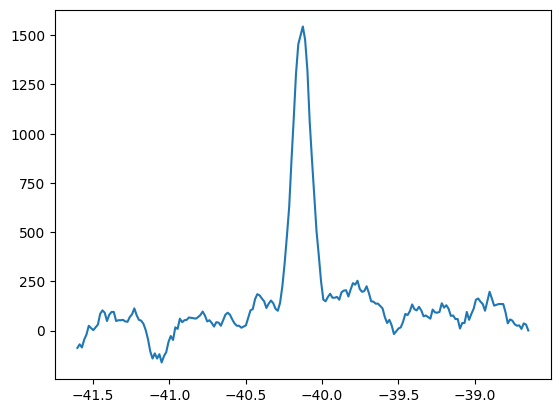

In [38]:
peak = np.max(data)
peak_loc = np.unravel_index(np.argmax(data),data.shape)
window = 100

if peak_loc[1]-window < 0:
    data_windowed = data[peak_loc[0]-window:peak_loc[0]+window,0:peak_loc[1]+window]
else:
    data_windowed = data[peak_loc[0]-window:peak_loc[0]+window,peak_loc[1]-window:peak_loc[1]+window]


if peak_loc[1]-window < 0:
    xfit_xcut = 1* xlab[0:peak_loc[1]+window]
    
else:
    xfit_xcut = 1* xlab[peak_loc[1]-window:peak_loc[1]+window]

yfit_xcut = data[peak_loc[0]-window:peak_loc[0]+window,peak_loc[1]]

if yfit_xcut.shape > xfit_xcut.shape :
    yfit_xcut = np.delete(yfit_xcut,0)

plt.plot(xfit_xcut,yfit_xcut)
#plt.plot(xlab[peak_loc[0]-window:peak_loc[0]+window], data[peak_loc[0]-window:peak_loc[0]+window,peak_loc[1]])
#plt.plot(data)

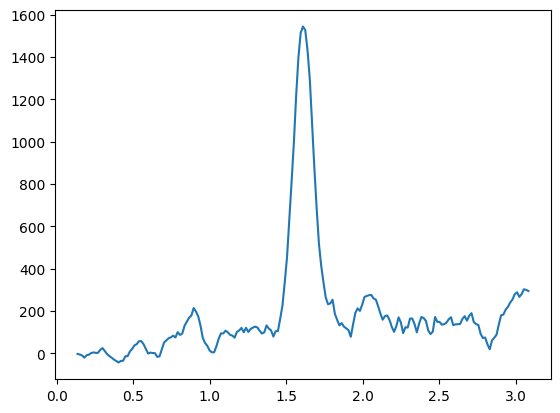

In [35]:
xfit_ycut =ylab[peak_loc[0]-window:peak_loc[0]+window]
yfit_ycut = data[peak_loc[0],peak_loc[1]-window:peak_loc[1]+window]

if peak_loc[1]-window < 0:
    yfit_ycut = data[peak_loc[0],0:peak_loc[1]+window]
else:
    yfit_ycut = data[peak_loc[0],peak_loc[1]-window:peak_loc[1]+window]

if yfit_ycut.shape < xfit_ycut.shape :
    xfit_ycut = np.delete(xfit_ycut,0)

plt.plot(xfit_ycut,yfit_ycut)


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 199
    # variables        = 3
    chi-square         = 2027558.28
    reduced chi-square = 10344.6851
    Akaike info crit   = 1842.57856
    Bayesian info crit = 1852.45847
    R-squared          = 0.87020933
[[Variables]]
    amplitude:  250.579627 +/- 7.35446180 (2.93%) (init = 343.1226)
    center:    -40.1319871 +/- 0.00223649 (0.01%) (init = -40.13315)
    sigma:      0.06599105 +/- 0.00223649 (3.39%) (init = 0.06705)
    fwhm:       0.15539705 +/- 0.00526653 (3.39%) == '2.3548200*sigma'
    height:     1514.85402 +/- 44.4609903 (2.94%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = +0.5774


c:\Users\ajo5182\AppData\Local\miniconda3\envs\xhcd\Lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


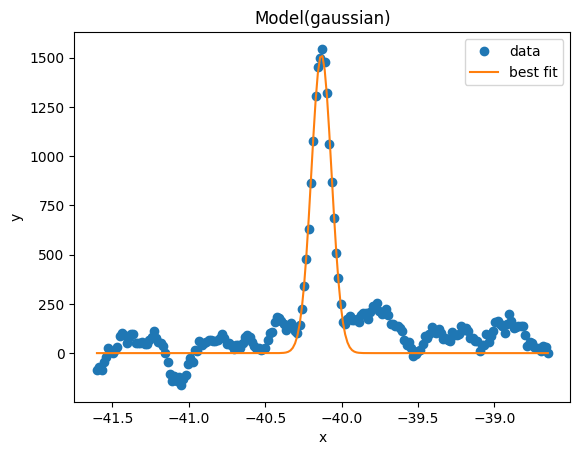

In [29]:
Xmodel  = GaussianModel()
params = Xmodel.guess(yfit_xcut, xfit_xcut)
Xresult = Xmodel.fit(yfit_xcut, params,x = xfit_xcut)
Xresult.plot_fit()
print(Xresult.fit_report())

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude       276     -inf      inf    9.973     True     None     None
center        1.613     -inf      inf 0.003042     True     None     None
fwhm         0.1716     -inf      inf 0.007162    False 2.3548200*sigma     None
height         1510     -inf      inf    54.58    False 0.3989423*amplitude/max(1e-15, sigma)     None
sigma       0.07289        0      inf 0.003042     True     None     None


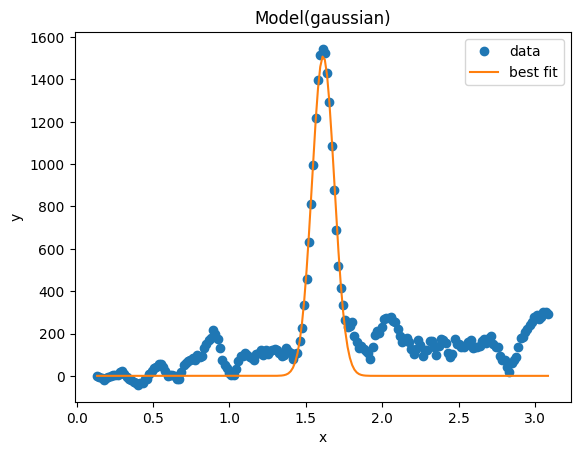

In [41]:
Ymodel  = GaussianModel()
params = Xmodel.guess(yfit_ycut, xfit_ycut)
Yresult = Xmodel.fit(yfit_ycut, params,x = xfit_ycut)
Yresult.plot_fit()
#print(Yresult.fit_report())
Yresult.params.pretty_print()
fwhm = Yresult.params["fwhm"]

In [40]:
fwhm.value

np.float64(0.17164708456456979)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (200, 0) and arg 2 with shape (200, 199).

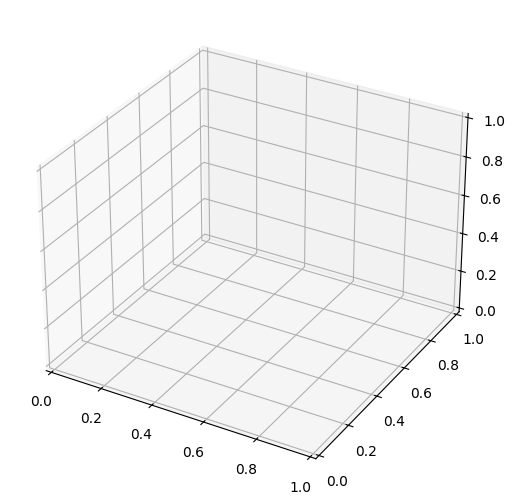

In [39]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
X,Y = np.meshgrid(-1* xlab[peak_loc[1]-window:peak_loc[1]+window],ylab[peak_loc[0]-window:peak_loc[0]+window])
ax.plot_surface(X,Y, data_windowed)

#params2d = fitgaussian(data_windowed)

In [ ]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p


param2d = fitgaussian(data_windowed)

In [ ]:
test= data_windowed(xfit_xcut, xfit_ycut)